# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = ".kaggle"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

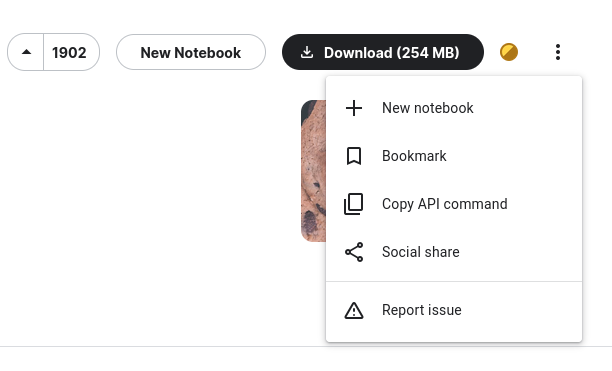

The copy-pasted command is the one shown below:

In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews


  0%|          | 0.00/242M [00:00<?, ?B/s]
  0%|          | 1.00M/242M [00:00<03:09, 1.34MB/s]
  1%|          | 2.00M/242M [00:01<02:11, 1.91MB/s]
  1%|1         | 3.00M/242M [00:01<01:45, 2.37MB/s]
  2%|1         | 4.00M/242M [00:01<01:36, 2.58MB/s]
  2%|2         | 5.00M/242M [00:02<01:30, 2.76MB/s]
  2%|2         | 6.00M/242M [00:02<01:27, 2.84MB/s]
  3%|2         | 7.00M/242M [00:02<01:31, 2.68MB/s]
  3%|3         | 8.00M/242M [00:03<01:32, 2.66MB/s]
  4%|3         | 9.00M/242M [00:03<01:27, 2.79MB/s]
  4%|4         | 10.0M/242M [00:04<01:40, 2.42MB/s]
  5%|4         | 11.0M/242M [00:04<01:54, 2.12MB/s]
  5%|4         | 12.0M/242M [00:05<01:54, 2.11MB/s]
  5%|5         | 13.0M/242M [00:06<02:11, 1.83MB/s]
  6%|5         | 14.0M/242M [00:06<01:49, 2.18MB/s]
  6%|6         | 15.0M/242M [00:06<01:42, 2.32MB/s]
  7%|6         | 16.0M/242M [00:07<01:34, 2.52MB/s]
  7%|7         | 17.0M/242M [00:07<01:29, 2.65MB/s]
  7%|7         | 18.0M/242M [00:07<01:29, 2.62MB/s]
  8%|7         | 19.

In [ ]:
!chmod 600 ./kaggle/kaggle.json

We next check that everything is there:

In [ ]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [7]:
from zipfile import ZipFile
from pathlib import Path

In [8]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
    Path("./data").mkdir(exist_ok=True, parents=True)
   # Extract all the contents of zip file in current directory
    zipObj.extractall("./data")

Let's check what files are there (we are looking for ```Reviews.csv```)

In [9]:
!ls data

database.sqlite
hashes.txt
Reviews.csv


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [10]:
!head -10 data/Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

#### Load the Reviews file.
As a first step, we load the `Reviews.csv` file.

In [1]:
import pandas as pd
raw_pd = pd.read_csv("data/Reviews.csv", index_col=0)

We write the sampled rows to the file, with columns separated by tab `\t` instead of comma `,` since there is a lot of free text in the reviews which might also contain commas.

In [2]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout

def sample_users(raw_pd, rate, buckets, fout):
    for index, row in raw_pd.iterrows():
        if (hash(row["UserId"])%buckets < rate):
            row_str = "\t".join(map(str, row))
            fout.write(row_str)
            fout.write("\n")
            # Save this line to fout
            # You have to complete this part of the function's body


sampled_file = "data/Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w", encoding="utf-8")
sample_users(raw_pd, rate, buckets, fout)
fout.close()

Load the sampled reviews from disk, specifying the `\t` as a separator and giving it the original column names.

In [3]:
sampled_reviews = pd.read_csv("data/Reviews_sampled.csv", header=None, sep="\t", names=raw_pd.columns)

FileNotFoundError: [Errno 2] No such file or directory: 'Reviews_sampled.csv'